dqn_owl.ipynb

### Setting up Owl Environment and ensuring it works

In [1]:
import sys
sys.path.append('../')
from deep_rl_old.component.owl import *
from deep_rl_old.component.fourrooms import *

/home/surya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize)/kernelSize, 'valid')
    return array

In [3]:
env = OwlTabular()
env.reset(), env.step(0)

(36, (33, 0, False, {}))

In [4]:
env = Owl()
env.reset(), env.step(0)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]), -1, False, {}))

### Run DQN on 4 rooms

In [4]:
import sys
sys.path.append('../')
from deep_rl_old import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [5]:
select_device(-1)

In [6]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, .1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if(agent.total_steps % 5000 == 0):
            print(agent.total_steps)
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [7]:
game = 'Owl'
agent = dqn_feature(game=game)

0


/home/surya/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


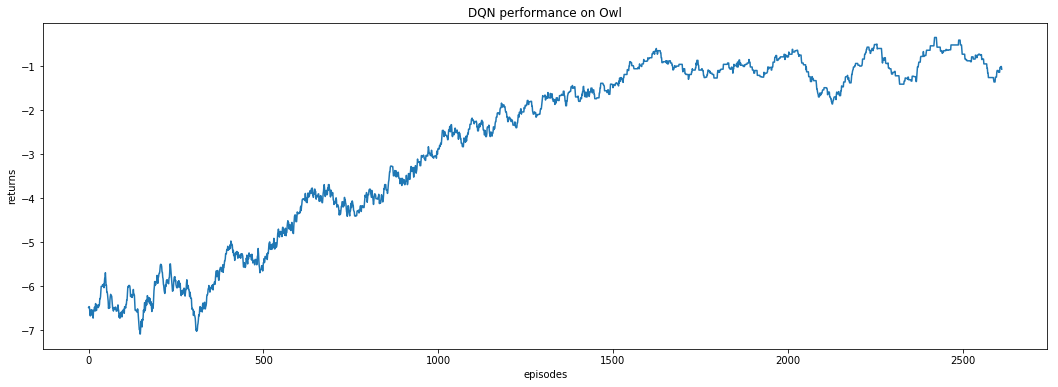

(Text(0.5,1,'DQN performance on Owl'), None)

In [13]:
plt.figure(figsize=(18,6))
plt.plot(convolve(np.array(agent.returns)[:,1], 100), '-')
plt.xlabel('episodes'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

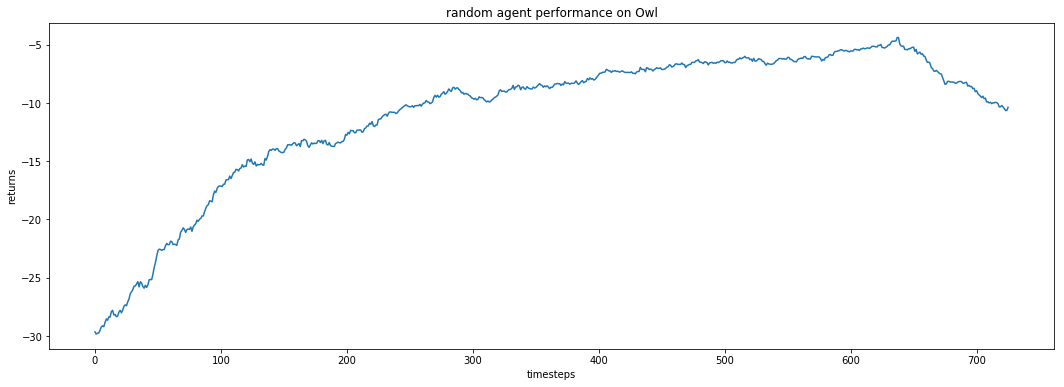

(Text(0.5,1,'random agent performance on Owl'), None)

In [8]:
plt.figure(figsize=(18,6))
plt.plot(convolve(np.array(agent.returns)[:,1],100), '-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('random agent performance on ' + game), plt.show()

In [11]:
env = Owl()
state = env.reset()
ims = []
for i in tqdm(range(100)):
    action = int(torch.argmax(agent.network(state)))
    state, _, done, _ = env.step(action)
    env.render(mode='png', name='{0:03d}'.format(i))
    if(done):
        env.reset()
        continue

In [12]:
import imageio
import os
filenames = []
for file in os.listdir('.'):
    filename = os.fsdecode(file)
    if filename.endswith( ('.png') ):
        filenames.append(filename)
        
filenames.sort() # this iteration technique has no built in order, so sort the frames

images = list(map(lambda filename: imageio.imread(filename), filenames))

imageio.mimsave(os.path.join('movie.gif'), images, duration = 0.1) # modify duration as needed

for file in filenames:
    os.remove(file)

## Tabular q-learning agent

In [3]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from PIL import Image, ImageDraw, ImageFont
from random import sample

In [31]:
class TabularQAgent:
    # Setting things up
    def __init__(self, env, eps=0.2, gamma = 1):
        self.noStates = env.observation_space.n
        self.noActions = env.action_space.n
        self.env = env
        self.Q = np.zeros((self.noStates, self.noActions))
        self.eps = eps
        self.gamma = gamma
        self.updates = 0
        
    def reset(self):
        self.Q = np.zeros((self.noStates, self.noActions))
        self.env.reset()
    
    # Function to do eps-greedy exploration
    def select_action(self, state, greedy=False):
        if(greedy):
            return np.argmax(self.Q[self.env.state, :])
        
        thresh = np.random.rand()
        if(thresh < self.eps): # Explore
            return self.env.action_space.sample()
        else: # Exploit
            greedy_actions = np.where(self.Q[state, :]==np.amax(self.Q[state, :]))
            return np.random.choice(greedy_actions[0])
        
    # Function for SARSA policy updates
#     def updatePolicySARSA(self, S, A, R, S2, A2, alpha):
#         self.updates = self.updates + 1
#         self.Q[S,A] = self.Q[S,A] + alpha * (R + self.gamma * self.Q[S2, A2] - self.Q[S,A])
    
    # Function for Qlearning policy updates
    def update(self, S, A, R, S2, lr=0.1):
        self.updates = self.updates + 1
        self.Q[S,A] = self.Q[S,A] + lr * (R + self.gamma * np.max(self.Q[S2, :]) - self.Q[S,A])
        
    def train(self, no_episodes=200, horizon=1000, lr=0.1, track=True):
        self.reset()
        R_vec = []
        ts = 0
        
        for i in tqdm(range(no_episodes), leave=True):
            state = self.env.reset()
            for t in range(horizon):
                action = self.select_action(state)
                state2, r, done, _ = self.env.step(action)
                ts += 1
                self.update(state, action, r, state2)
                if(track):
                    R_vec.append(r)
                if(done):
                    break
                state = state2

        return R_vec, self.Q, ts
    
    def train_multiple_ts(self, runs=5, max_ts=20000, horizon=1000, lr=0.1, track=True):
        """
        This function trains the agent on the environment multiple times. The stopping
        criterion is number of timesteps.
        """
        R_mat = []; Q_vec=[]
        for j in range(runs):
            R_vec = []
            self.reset()
            ts = 0
            state = self.env.reset()
            for i in tqdm(range(max_ts), leave=True):
                action = self.select_action()
                state2, r, done, _ = self.env.step(action)
                self.update(state, action, r, state2)
                if(track):
                    R_vec.append(r)

                if(done):
                    state = self.env.reset()
                    continue

                state = state2
            R_mat.append(R_vec)
            Q_vec.append(self.Q)

        return R_mat, Q_vec

In [32]:
env = OwlTabular()
q_agent = TabularQAgent(env)

In [6]:
R_vec, Q_vec, ts = q_agent.train()

100%|██████████| 200/200 [00:00<00:00, 267.25it/s]


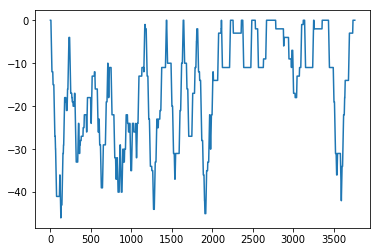

In [7]:
plt.plot(np.convolve(R_vec, np.ones(100)))

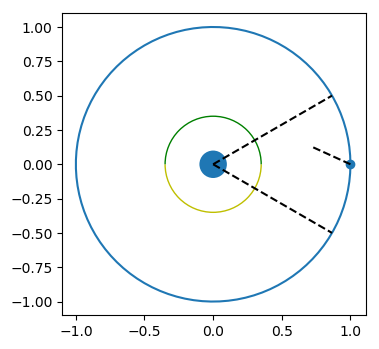

In [34]:
env.reset()
env.render()

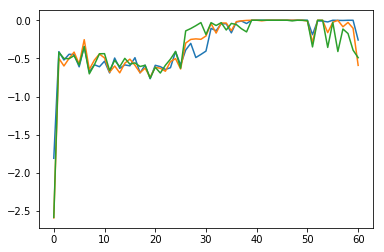

In [9]:
plt.plot(Q_vec)

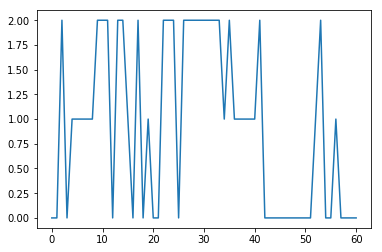

In [12]:
plt.plot(np.argmax(q_agent.Q,axis=1))

(0, -1, False, {})


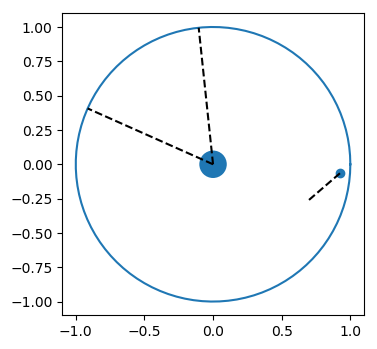

In [89]:
env.reset()
print(env.step(env.action_space.sample()))
env.render()

In [54]:
import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

class Owl(gym.Env):
    """
    Description: 
        The agent is at the center of the circle. It hears sounds
        through both it's ears and it sees objects in front. The agent
        needs to turn it's head towards moving preys.
    
    """
    
    def __init__(self):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=np.zeros(60), high=np.ones(60), dtype=np.uint8)
        self.view_angle = 0
        self.rot_speed = np.pi / 10
        self.prey = True
        self.action_space = spaces.Discrete(3)
        self.horizon = 100
        self.steps = 0
        # Random number generator
        self.rng = np.random.RandomState(1234)
        
    def reset(self):
        self.preys()
        self.steps = 0
        prey_angle = np.arctan2(self.prey_location[1], self.prey_location[0])
        error = np.abs(prey_angle - self.view_angle)
        eyes = np.zeros(60)
        if(error < np.pi/6):
            mask_loc = 60 - (30 + (prey_angle - self.view_angle) * 30 * 6 / np.pi)
            eyes[int(mask_loc)] = 1

        return eyes

    def seed(self, seed=None):
        """
        Setting the seed of the agent for replication
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def step(self, action):
        done = False
        
        # Update prey location
        self.prey_location += self.prey_speed * self.prey_dirn_vec
            
        # Update animal view
        self.view_angle += (action-1) * self.rot_speed
        
        # Calculate reward
        prey_angle = np.arctan2(self.prey_location[1], self.prey_location[0])
        error = np.abs(prey_angle - self.view_angle)
        # R = -error
        R = -1

        # Calculate observation
        eyes = np.zeros(60)
        if(error < np.pi/6):
            R = 0
            mask_loc = 60 - (30 + (prey_angle - self.view_angle) * 30 * 6 / np.pi)
            eyes[int(mask_loc)] = 1

        # Calculate done
        self.steps += 1
        if(self.steps>=self.horizon or np.linalg.norm(self.prey_location) > 1):
            done = True
            
        return eyes, R, done, {}
            
        
    def preys(self):
        self.prey_speed = 0.1
        self.prey_location = np.array([1, 0])
#         self.prey_location = np.random.rand(2)-0.5
        self.prey_location = self.prey_location / np.linalg.norm(self.prey_location)
        prey_angle = np.arctan2(self.prey_location[1],self.prey_location[0])
        self.prey_direction = prey_angle + np.pi + np.pi/2 * (np.random.rand() - 0.5)
        self.prey_dirn_vec = np.array([np.cos(self.prey_direction), np.sin(self.prey_direction)])
        self.prey_size = 0.1
    
    def render(self, mode='human'):
        fig, ax = plt.subplots(dpi=100)
        
        # plot boundary
        rads = np.linspace(0, 2 * np.pi, 100)
        ax.plot(np.cos(rads), np.sin(rads))
        ax.set_aspect('equal', 'box')
        
        # plot prey
        if(self.prey):
            ax.scatter(self.prey_location[0], self.prey_location[1])
            ax.plot([self.prey_location[0], self.prey_location[0] + 3 * self.prey_speed * self.prey_dirn_vec[0]], \
                    [self.prey_location[1], self.prey_location[1] + 3 * self.prey_speed * self.prey_dirn_vec[1]], \
                   'k--')
            
        # plot animal
        ax.add_artist(plt.Circle((0,0),0.1))
        left_angle = self.view_angle - np.pi/6
        right_angle = self.view_angle + np.pi/6
        ax.plot([0,np.cos(left_angle)], [0, np.sin(left_angle)], 'k--')
        ax.plot([0,np.cos(right_angle)], [0, np.sin(right_angle)], 'k--')
        
        plt.show()
        
class OwlTabular(Owl):
    def __init__(self):
        Owl.__init__(self)
        self.observation_space = spaces.Discrete(61)

    def reset(self):
        obs = Owl.reset(self)
        if(np.sum(obs) == 0):
            return 0
        else:
            return 1 + np.where(obs==1)[0][0]

    def step(self, action):
        obs, R, done, info = Owl.step(self, action)
        if(np.sum(obs) == 0):
            return 0, R, done, info
        else:
            return 1 + np.where(obs==1)[0][0], R, done, info 
